# CFEP0. The cut-based free energy profiles

In this series of notebooks we will describe the cut-based free energy profiles (CFEP) and illustrate their usage in analysis of free energy landscapes (FEL), diffusive dynamics, and optimality of reaction coordinates (RC). In particular we will:
 - Introduce the family of $Z_{C,\alpha}(x,\Delta t)$ profiles and describe how they can be computed from reaction coordinate timeseries $r(i\Delta t)$.
 - Show how these profiles can be used to compute the conventional, histogram-based, free energy profile $F_H(x)$ and position dependent diffusion coefficient $D(x)$.
 - Show how the profiles can be used to compute various properties of kinetics, e.g. the equilibrium flux, the mean first passage times, and the mean transition path times.
 - Show how these profiles, namely $Z_{C,1}(x,\Delta t)$ can be used to test the optimality of a putative reaction coordinate, i.e., how close this coordinate is to the committor, and which regions of the coordinate are most suboptimal.
 - Show how a combination of these profiles, namely the $\theta(x,\Delta t)$ function, can be used to check how close is the putative reaction coordinate to an eigenvector of the transfer operator, and what regions of the coordinate are most suboptimal.

#### HFEP
Consider first, conventional, histogram based free energy profile. Consider a short segment of trajectory, time-series of reaction coordinate r(t)=[0.1, 0.3, 0.4]. To build the histogram, one divide the coordinate into bins with size $\Delta x$, count how many times the trajectory visited a particular bin, denoted as $n_{x,x+\Delta x}$. The partition function, which estimates the probability density equal then $Z_H(x)=n_{x,x+\Delta x}/\Delta x$. For the segment of trajectory considered here, one obtains 3 peaks around 0.1, 0.3, and 0.4 of width $\Delta x$ and height $1/\Delta x$. The free energy profile equals then $F(x)/kT=-\ln Z_H(x)$.

#### CFEP

$Z_{C,\alpha}(x,\Delta t)$ is computed in the following way. For every transition in the trajectory, from $r(t)$ to $r(t+\Delta t)$ one adds half the length of the transition to the power $r$: $|r(t+\Delta t)-r(t)|^\alpha/2$ to all the points between $r(t+\Delta t)$ and $r(t)$. 

For example, $Z_{C,1}$, for the segment of trajectory considered above, which has two transitions $0.1 \rightarrow 0.3$ and $0.3 \rightarrow 0.4$, looks like the following:

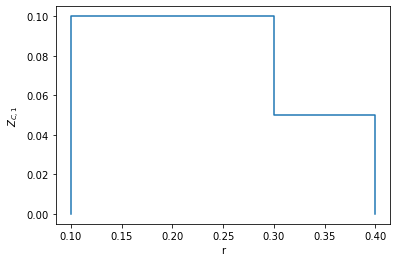

In [1]:
lx=[0.1,0.1,0.3,0.3,0.4,0.4]
ly=[0,0.1,0.1,0.05,0.05,0]
%matplotlib inline
import matplotlib.pyplot as plt
plt.xlabel('r')
plt.ylabel('$Z_{C,1}$')
_=plt.plot(lx,ly)

Function comp_Zca from the cfeplib library can be used to compute $Z_{C,r}(x,\Delta t)$ for/from an arbitrary trajectory time-series:

comp_Zca(lx, a, dt=1, strict=False, dx=1e-3, zcmin=1e-8, mindx=1e-3)

Select strict=True to obtain the exact profile; strict=False results in a slightly less accurate profile, computed faster and with output arrays/lists consuming less memory. In particular it happens due to coarse-graining/binning the trajectory with bin size $dx$. 

zcmin controls the roundoff errors; as zc is always positive, so if zc<zcmin, then zc=0.
mindx bounds $\Delta x^r$ for negative $r$ by providing a lower bound for $\Delta x$.

For the segment of trajectory considered above one obtains the same profile. You can play with trajectory and the function parameters to get familiar with the profiles.

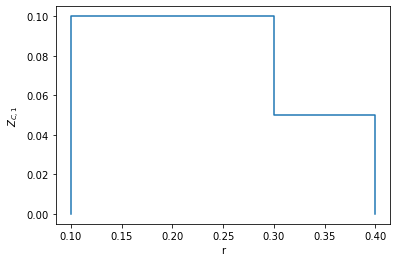

In [2]:
from cfeplib import comp_Zca
lr=[0.1,0.3,0.4]
lx,ly=comp_Zca(lr,a=1,strict=True)
plt.xlabel('r')
plt.ylabel('$Z_{C,1}$')
_=plt.plot(lx,ly)

###  Using CFEPs to determine the free energy profile and position dependent diffusion coefficient

The free energy profile and diffusion coefficient, $F(r)$ and $D(r)$, completely specify a diffusive model of the dynamics projected on reaction coordinate r. A number of different approaches of various complexity has been suggested to solve the important problem of how to determine them in practice. Here we show how these quantities can be determined, rather straightforwardly, using CFEPs. The main assumption is that the trajectory sampling interval $\Delta t$ is relatively small. 

Before going further, recall that $Z_{C,\alpha}(x,\Delta t)\approx 1/2 Z_H(x)\langle |\Delta x|^{\alpha+1}\rangle$ in the regime of small $|\Delta x|$ or small $\Delta t$ [1]. In particular for diffusive motion one has [1]:
 - $Z_{C,0}(x,\Delta t)=Z_H(x)\sqrt{D(x) \Delta t/\pi}$
 - $Z_{C,1}(x,\Delta t)=Z_H(x)D(x) \Delta t$
 - $Z_{C,-1}(x,\Delta t)=Z_H(x)/2$
 
Thus one can determine the free energy profile as
$$F_H/kT=-\ln Z_H(x)=-\ln 2 Z_{C,-1}(x)$$
 
The diffusion coefficient can be determined as 
$$D(x)=\frac{Z_{C,1}(x)}{2 \Delta t Z_{C,-1}(x)}$$ or 
$$D(x)=\frac{\Delta t}{\pi}(\frac{Z_C(x)}{2 Z_{C,-1}(x)})^2$$
 
Next we illustrate these equations on a model system with position dependent diffusion coefficient. We will use function *comp_diffusion* to compute diffusion trajectory for  drift $f(x)=-x$ and diffusion coefficient $D(x)=(1+\cos(x))/2$

In [3]:
import math
from cfeplib import comp_diffusion_euler

# specifying the drift
def f(x):
    return -x

# specifying the diffusion coefficient
def D(x):
    return (1+math.cos(x))/2

dt=0.01
traj=comp_diffusion_euler(f,D,dt,1000000)

Next, we compute the above CFEPs and use them to estimate the diffusion coefficient.

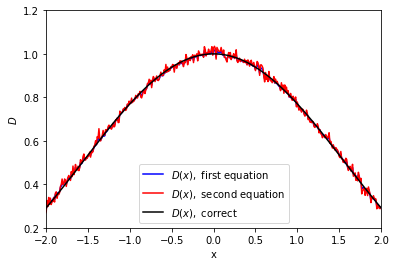

In [4]:
# compute Z_C,1, Z_C,-1 and Z_C
lx1,lzc1=comp_Zca(traj,a=1,dx=0.01)
lx2,lzcn1=comp_Zca(traj,a=-1,dx=0.01)
lx3,lzc=comp_Zca(traj,a=0,dx=0.01)

# compute diffusion coefficient using 1 and 2 equations
ld1=[zc1/zcn1/2/dt for zc1,zcn1 in zip(lzc1,lzcn1)]
ld2=[(zc/zcn1/2)**2/dt*math.pi for zc,zcn1 in zip(lzc,lzcn1)]

# make plot
plt.xlabel('x')
plt.ylabel('$D$')
plt.plot(lx1,ld1,'b',label='$D(x),$ first equation')
plt.plot(lx1,ld2,'r',label='$D(x),$ second equation')
plt.plot(lx1,[D(x) for x in lx1],'k',label='$D(x),$ correct')
plt.legend()
plt.xlim(-2,2)
_=plt.ylim(0.2,1.2)

As one can see, both the estimates are rather close to the true value of the diffusion coefficient $D(x)$. Decreasing $\Delta t$ improves the agreement.

Next we determine the free energy profiles. Free energy profile, corresponding to the equilibrium distribution for the diffusion with drift $f(x)$ and diffusion coefficient $D(x)$ can be found analytically as

$$F(x)/kT=\ln D(x) - \int \frac{f(x)}{D(x)}dx$$

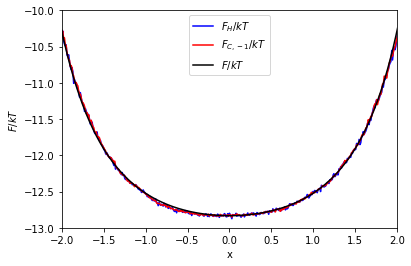

In [5]:
from cfeplib import comp_Zh

dx=0.01
# compute and plot F from Z_H
lx4,ly4=comp_Zh(traj,dx=dx)
lf4=[-math.log(y) for y in ly4]
plt.plot(lx4,lf4,'b-',label='$F_H/kT$')

# compute and plot F from Z_C,-1
lx5,ly5=comp_Zca(traj,a=-1,dx=dx)
lf5=[-math.log(2*y) for y in ly5]
plt.plot(lx5,lf5,'r-',label='$F_{C,-1}/kT$')


# compute and plot analytical free energy profile
lx=[i*0.01 for i in range(-300,301)]
lD=[D(x) for x in lx]
lfD=[-f(x)/D(x) for x in lx]
    
from scipy.integrate import cumtrapz
lI=cumtrapz(lfD,lx,initial=0)
lF=[I+math.log(D) for I,D in zip(lI,lD)]

# shift F, so that plots conside
du=lF[300]-lf5[int(len(lf5)/2)]
lF=[u-du for u in lF]

plt.plot(lx, lF,'k-',label='$F/kT$')

plt.legend()
plt.xlabel('x')
plt.ylim((-13,-10))
plt.xlim((-2,2))
_=plt.ylabel('$F/kT$')


Again, both free energy profiles, estimated from $Z_H$ and $Z_{C,-1}$ are in very good agreement between themselves and with $F(x)$. Decreasing $dx$, increases the spatial resolution of $Z_H$, while increases the statistical noise as well; try, for example, dx=0.001. For $Z_{C,-1}$ small $dx$ do not result in increased noise and one can use as small $dx$ as desirable.

The employed sampling interval $\Delta t = 0.01$ is sufficiently small so that the free energy profile and diffusion coefficient can be estimated with high accuracy. Acceptable estimates can be obtained for larger $\Delta t$; try, for example, $\Delta t=0.1$.

### In summary,
the cut-based free energy profiles $Z_{C,\alpha}$ can be straightforwardly computed from the reaction coordinate time-series $r(i\Delta).$ They can be used to estimate the free energy profile $F(r)$ and the diffusion coefficient $D(r)$, and thus completely specify the diffusive model, describing the dynamics. In the next notebook we show, how the model can be used to compute important properties of the kinetics. 

### References

[1] S. V. Krivov, On Reaction Coordinate Optimality, *Journal of Chemical Theory and Computation* 2013 **9** (1), 135-146 